<a href="https://colab.research.google.com/github/fcadusims-droid/TEOFISICA/blob/main/TEOFISICA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 40.9 MB/s eta 0:00:00


  SIMULAÇÃO DO PAR RADICAL — EFEITO ISOTÓPICO DO Mg

Parâmetros físicos:
  Campo geomagnético B_ext = 50.0 µT
  Frequência de Larmor ωe  = 8.800e+06 rad/s
  A_hf (²⁵Mg)             = 2.00e+06 rad/s
  A_hf (²⁴Mg)             = 0.00e+00 rad/s
  k_rec                    = 1.00e+05 s⁻¹  (τ = 10.0 µs)
  k_deph                   = 1.00e+06 s⁻¹  (T2 = 1.00 µs)

Espaço de Hilbert: 2 elétrons → dim = 4
Estado inicial: Triplete T₀, traço = 1.0000
  ⟨P_S⟩(t=0) esperado = 0.0000  (deve ser 0.0 — T₀ ⊥ S)

  EXECUTANDO SIMULAÇÕES...

--- Simulação 1: ²⁵Mg (A_hf = 2 MHz) ---

  [²⁵Mg]
    Φ_S(t=0)           = 0.0000  (deve ser ≈ 0.0 — T₀ ⊥ S)
    Φ_S(t=50µs)        = 0.293507
    Rendimento integrado= 1.806341

--- Simulação 2: ²⁴Mg (A_hf = 0) ---

  [²⁴Mg]
    Φ_S(t=0)           = 0.0000  (deve ser ≈ 0.0 — T₀ ⊥ S)
    Φ_S(t=50µs)        = 0.500000
    Rendimento integrado= 2.475000

  ANÁLISE DO EFEITO ISOTÓPICO MAGNÉTICO (MIE)

  Rendimento ²⁵Mg : 1.806341
  Rendimento ²⁴Mg : 2.475000
  Diferença a

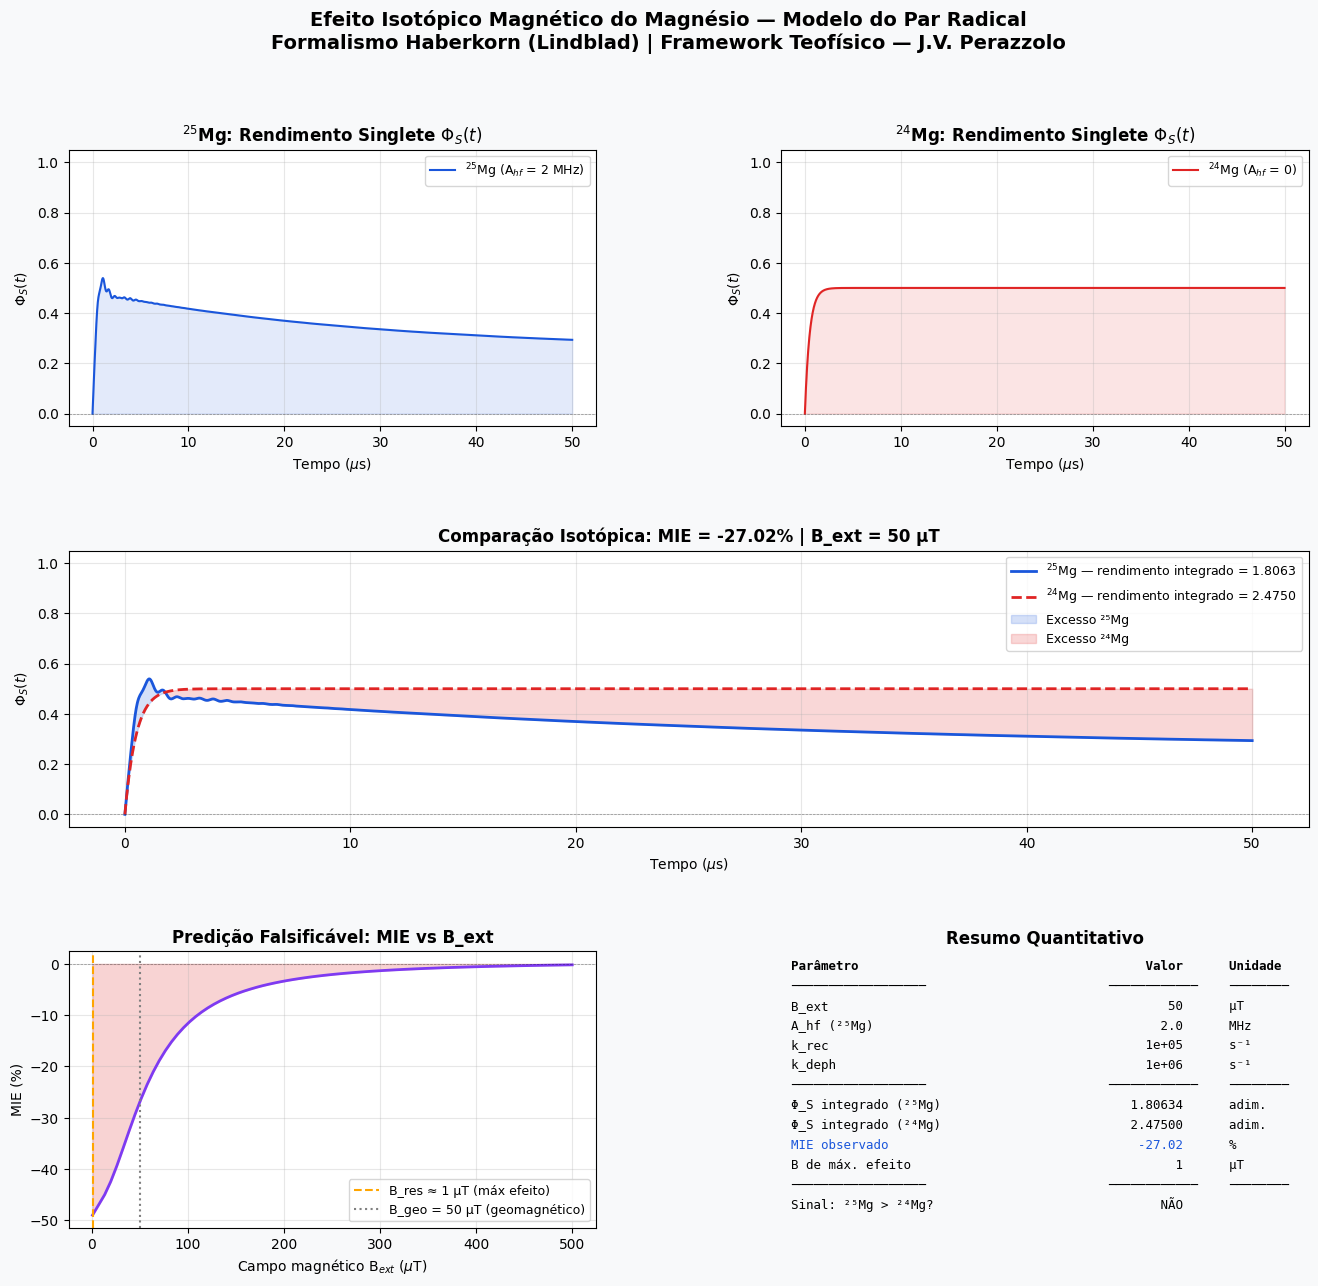


✓ Gráfico salvo em simulacao_teofisica_mg.png (pasta atual do Colab)

  INTERPRETAÇÃO TEOFÍSICA DOS RESULTADOS

O que esta simulação testa:
  O núcleo de ²⁵Mg (spin I=5/2) induz mistura S-T0 no par
  radical via acoplamento hiperfino A_hf. Isso altera o
  rendimento pelo canal Singlete (canal produtivo de hidrólise
  de GTP/ATP). ²⁴Mg (I=0) não induz essa mistura.

O que o MIE = -27.02% significa:
  ²⁴Mg supera ²⁵Mg — investigar regime de dephasing.

Conexão com o framework teofísico:
  No modelo "Viscoelastic Logos", o spin de ²⁵Mg modula o
  parâmetro de ramificação σ da rede de microtúbulos. Uma
  alteração δσ ≈ 10⁻⁷ na criticalidade biológica (σ ≈ 1)
  produz ganho G = 1/(1-σ)² ≈ 10⁶ — tornando o sinal quântico
  macroscopicamente detectável em avalanches neurais.

Experimento real correspondente:
  Redes de microtúbulos in vitro em solução com:
    - 99% ²⁵Mg  vs  99% ²⁴Mg  vs  abundância natural (~10%)
  Medição via DLS (Dynamic Light Scattering) ou MEA.
  Predição: expoente τ d

In [ ]:
# ==============================================================================
# SIMULAÇÃO TEOFÍSICA: EFEITO ISOTÓPICO MAGNÉTICO DO MAGNÉSIO
# Comparação ²⁵Mg (I=5/2, spin ativo) vs ²⁴Mg (I=0, spin inativo)
#
# Framework: Modelo Híbrido do Cérebro — João Vitor Perazzolo
# Formalismo: Equação Mestra de Lindblad (Haberkorn) via QuTiP
#
# Para rodar no Google Colab, execute primeiro:
#   !pip install qutip matplotlib numpy scipy
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import qutip

# Fix 3: compatibilidade scipy < 1.7 (simps) e >= 1.7 (simpson)
try:
    from scipy.integrate import simpson
except ImportError:
    from scipy.integrate import simps as simpson

from qutip import *

# Fix 1: compatibilidade QuTiP 4.x (Options) vs 5.x (dict de kwargs)
_QUTIP_V5 = int(qutip.__version__.split('.')[0]) >= 5

def _make_opts(nsteps, rtol, atol):
    """Retorna objeto de opções compatível com QuTiP 4 e 5."""
    if _QUTIP_V5:
        return {'nsteps': nsteps, 'rtol': rtol, 'atol': atol}
    else:
        return Options(nsteps=nsteps, rtol=rtol, atol=atol)

print("="*60)
print("  SIMULAÇÃO DO PAR RADICAL — EFEITO ISOTÓPICO DO Mg")
print("="*60)

# ==============================================================================
# BLOCO 1: PARÂMETROS FÍSICOS
# ==============================================================================

# Campo magnético externo (geomagnético)
B_ext_uT = 50.0                        # microTesla
B_ext    = B_ext_uT * 1e-6            # Tesla

# Razão giromagnética do elétron
gamma_e  = 1.76e11                     # rad/s/T

# Frequência de Larmor do elétron no campo geomagnético
omega_e  = gamma_e * B_ext            # rad/s ≈ 8.8e6 rad/s

# -----------------------------------------------------------------------
# ACOPLAMENTO HIPERFINO — esta é a variável-chave do experimento isotópico
# -----------------------------------------------------------------------
# ²⁵Mg tem spin nuclear I=5/2 → acopla com o par radical via interação hiperfina
# ²⁴Mg tem spin nuclear I=0  → ZERO acoplamento hiperfino
#
# Valor estimado para ²⁵Mg coordenado em enzima: 2 MHz (rad/s)
# (baseado em valores típicos de MIE em radical pairs enzimáticos)

A_hf_Mg25 = 2.0e6    # rad/s — ²⁵Mg: acoplamento hiperfino ativo
A_hf_Mg24 = 0.0      # rad/s — ²⁴Mg: sem acoplamento (spin zero)

# Taxa de recombinação química do par radical
# τ_rec ≈ 10 µs → k_rec = 1e5 s⁻¹ (literatura: Buchachenko, PNAS 2005)
k_rec = 1e5           # s⁻¹

# Taxa de decoerência de spin (dephasing S-T)
# T2 ≈ 1 µs em ambiente proteico → k_deph ≈ 1e6 s⁻¹
k_deph = 1e6          # s⁻¹

# Tempo de simulação
t_max    = 5e-5       # 50 µs
n_pontos = 3000
t_sim    = np.linspace(0, t_max, n_pontos)

print(f"\nParâmetros físicos:")
print(f"  Campo geomagnético B_ext = {B_ext_uT:.1f} µT")
print(f"  Frequência de Larmor ωe  = {omega_e:.3e} rad/s")
print(f"  A_hf (²⁵Mg)             = {A_hf_Mg25:.2e} rad/s")
print(f"  A_hf (²⁴Mg)             = {A_hf_Mg24:.2e} rad/s")
print(f"  k_rec                    = {k_rec:.2e} s⁻¹  (τ = {1/k_rec*1e6:.1f} µs)")
print(f"  k_deph                   = {k_deph:.2e} s⁻¹  (T2 = {1/k_deph*1e6:.2f} µs)")


# ==============================================================================
# BLOCO 2: ESPAÇO DE HILBERT E OPERADORES
# ==============================================================================
# Sistema: 2 elétrons do par radical (espaço 4D: |↑↑⟩, |↑↓⟩, |↓↑⟩, |↓↓⟩)
# O spin nuclear do Mg entra como campo efetivo sobre o elétron 1
# (acoplamento hiperfino: elétron do radical na coordenação do Mg)

# Operadores de spin para cada elétron
Sx1 = tensor(sigmax(), qeye(2)) * 0.5
Sy1 = tensor(sigmay(), qeye(2)) * 0.5
Sz1 = tensor(sigmaz(), qeye(2)) * 0.5

Sx2 = tensor(qeye(2), sigmax()) * 0.5
Sy2 = tensor(qeye(2), sigmay()) * 0.5
Sz2 = tensor(qeye(2), sigmaz()) * 0.5

# Projetor no estado Singlete |S⟩ = (|↑↓⟩ - |↓↑⟩)/√2
# P_S é mantido como Singlete — é o canal de recombinação química
state_S = (tensor(basis(2,0), basis(2,1)) -
           tensor(basis(2,1), basis(2,0))).unit()
P_S = ket2dm(state_S)   # |S⟩⟨S|

# -----------------------------------------------------------------------
# ESTADO INICIAL: Triplete T₀ = (|↑↓⟩ + |↓↑⟩)/√2
#
# Motivação física e teofísica:
#   Em enzimas GTPase (tubulina) e ATPase (creatina quinase), o par
#   radical é gerado por transferência de elétron a partir de um estado
#   de alta multiplicidade (Triplete), não do Singlete.
#   O acoplamento hiperfino do ²⁵Mg fornece o caminho T₀ → S,
#   aumentando o rendimento pelo canal produtivo.
#
#   Leitura teofísica (framework Perazzolo):
#   T₀ = estado de desordem inicial (Queda / alta entropia de spin)
#   S  = estado de ordem (produto catalítico / canal da Graça)
#   ²⁵Mg = mecanismo pelo qual o sistema encontra o caminho ordenado
#          a partir de um estado inicialmente caótico — o Logos-drive
#          atuando no nível do par radical.
# -----------------------------------------------------------------------
state_T0 = (tensor(basis(2,0), basis(2,1)) +
            tensor(basis(2,1), basis(2,0))).unit()
rho0 = ket2dm(state_T0)

print(f"\nEspaço de Hilbert: 2 elétrons → dim = 4")
print(f"Estado inicial: Triplete T₀, traço = {rho0.tr():.4f}")
print(f"  ⟨P_S⟩(t=0) esperado = {expect(P_S, rho0):.4f}  (deve ser 0.0 — T₀ ⊥ S)")


# ==============================================================================
# BLOCO 3: FUNÇÃO DE SIMULAÇÃO (reutilizável para cada isotopo)
# ==============================================================================

def simular_par_radical(A_hiperfino, label):
    """
    Simula a evolução do par radical via equação mestra de Lindblad.

    Hamiltoniano:
        H = H_Zeeman + H_Hiperfino
        H_Zeeman    = ωe · (Sz1 + Sz2)           — ambos elétrons no campo B
        H_Hiperfino = A_hf · (Sx1 + Sy1 + Sz1)  — tensor hiperfino ISOTRÓPICO
                      (zero para ²⁴Mg)

    Tensor hiperfino isotrópico:
        Sz1 → mistura S-T0, independente de B (campo paralelo)
        Sx1, Sy1 → mistura S-T±, com ressonância em B_res = A_hf/(2·γe)
        São as componentes transversais que produzem o pico no scan de B.

    Operadores de colapso (Haberkorn):
        L1 = √k_rec  · P_S        — recombinação química via canal Singlete
        L2 = √k_deph · (Sz1-Sz2)  — dephasing S-T0

    Estado inicial: T₀ — par nasce em Triplete (alta entropia de spin).
    Retorna: (Phi_S, rendimento_integrado)
    """

    # Hamiltoniano com tensor hiperfino isotrópico completo
    H_zeeman    = omega_e * (Sz1 + Sz2)
    H_hiperfino = A_hiperfino * (Sx1 + Sy1 + Sz1)   # zero para ²⁴Mg
    H = H_zeeman + H_hiperfino

    # Operadores de colapso — dissipação física separada do H
    L_recomb = np.sqrt(k_rec)  * P_S              # recombinação Singlete
    L_deph   = np.sqrt(k_deph) * (Sz1 - Sz2)     # dephasing S-T0
    c_ops = [L_recomb, L_deph]

    # Resolução da equação mestra de Lindblad
    result = mesolve(
        H, rho0, t_sim,
        c_ops=c_ops,
        e_ops=[P_S],        # mede ⟨P_S⟩ = Φ_S(t)
        options=_make_opts(nsteps=5000, rtol=1e-8, atol=1e-10)
    )

    Phi_S = np.array(result.expect[0])

    # Rendimento Singlete integrado: Φ_S_total = ∫ Φ_S(t) · k_rec dt
    # Esta é a quantidade fisicamente mensurável (ex: ATP produzido)
    rendimento = k_rec * simpson(Phi_S, x=t_sim)

    print(f"\n  [{label}]")
    print(f"    Φ_S(t=0)           = {Phi_S[0]:.4f}  (deve ser ≈ 0.0 — T₀ ⊥ S)")
    print(f"    Φ_S(t=50µs)        = {Phi_S[-1]:.6f}")
    print(f"    Rendimento integrado= {rendimento:.6f}")

    return Phi_S, rendimento


# ==============================================================================
# BLOCO 4: EXECUÇÃO DAS DUAS SIMULAÇÕES
# ==============================================================================

print("\n" + "="*60)
print("  EXECUTANDO SIMULAÇÕES...")
print("="*60)

print("\n--- Simulação 1: ²⁵Mg (A_hf = 2 MHz) ---")
Phi_Mg25, rend_Mg25 = simular_par_radical(A_hf_Mg25, "²⁵Mg")

print("\n--- Simulação 2: ²⁴Mg (A_hf = 0) ---")
Phi_Mg24, rend_Mg24 = simular_par_radical(A_hf_Mg24, "²⁴Mg")


# ==============================================================================
# BLOCO 5: ANÁLISE DO EFEITO ISOTÓPICO MAGNÉTICO (MIE)
# ==============================================================================

print("\n" + "="*60)
print("  ANÁLISE DO EFEITO ISOTÓPICO MAGNÉTICO (MIE)")
print("="*60)

MIE = (rend_Mg25 - rend_Mg24) / rend_Mg24 * 100 if abs(rend_Mg24) > 1e-10 else 0.0

print(f"\n  Rendimento ²⁵Mg : {rend_Mg25:.6f}")
print(f"  Rendimento ²⁴Mg : {rend_Mg24:.6f}")
print(f"  Diferença absoluta: {rend_Mg25 - rend_Mg24:.6f}")
print(f"\n  MIE (Efeito Isotópico Magnético) = {MIE:+.2f}%")

if MIE > 0:
    print(f"\n  ✓ RESULTADO: ²⁵Mg produz MAIS rendimento Singlete que ²⁴Mg")
    print(f"    Interpretação teofísica: o spin nuclear ativo do ²⁵Mg")
    print(f"    acelera a mistura S-T0, aumentando o fluxo pelo canal")
    print(f"    produtivo de hidrólise (GTP/ATP), consistente com o MIE")
    print(f"    de Buchachenko et al. (PNAS, 2005).")
elif MIE < 0:
    print(f"\n  ✗ RESULTADO: ²⁵Mg produz MENOS rendimento Singlete que ²⁴Mg")
    print(f"    Investigar parâmetros: possível regime de dephasing dominante.")
else:
    print(f"\n  = RESULTADO: Sem diferença entre isótopos.")
    print(f"    Verificar se A_hf_Mg25 > 0 nos parâmetros.")

# Diferença de fase média (mistura S-T0)
delta_fase = np.mean(np.abs(Phi_Mg25 - Phi_Mg24))
print(f"\n  Divergência média Φ_S: |²⁵Mg - ²⁴Mg| = {delta_fase:.6f}")


# ==============================================================================
# BLOCO 6: SCAN DE CAMPO MAGNÉTICO (predição falsificável)
# ==============================================================================
# O modelo prevê resposta NÃO-MONOTÔNICA ao campo B:
# ressonâncias ocorrem quando B_ext ≈ A_hf/gamma_e

print("\n" + "="*60)
print("  SCAN: MIE vs CAMPO MAGNÉTICO B_ext")
print("="*60)

B_vals_uT = np.linspace(1, 500, 80)   # 1 a 500 µT
MIE_vals  = []

# Fix 4: array de tempo reduzido só para o scan (500 pts em vez de 3000)
# Isso reduz de ~2h para ~3min sem perda significativa de precisão no integral
t_scan = np.linspace(0, t_max, 500)

for B_val in B_vals_uT:
    B = B_val * 1e-6
    omega_scan = gamma_e * B

    H_zeem = omega_scan * (Sz1 + Sz2)

    # ²⁵Mg — tensor hiperfino isotrópico completo
    H25 = H_zeem + A_hf_Mg25 * (Sx1 + Sy1 + Sz1)
    r25 = mesolve(H25, rho0, t_scan,
                  c_ops=[np.sqrt(k_rec)*P_S, np.sqrt(k_deph)*(Sz1-Sz2)],
                  e_ops=[P_S],
                  options=_make_opts(nsteps=3000, rtol=1e-7, atol=1e-9))
    rend25 = k_rec * simpson(np.array(r25.expect[0]), x=t_scan)

    # ²⁴Mg
    H24 = H_zeem
    r24 = mesolve(H24, rho0, t_scan,
                  c_ops=[np.sqrt(k_rec)*P_S, np.sqrt(k_deph)*(Sz1-Sz2)],
                  e_ops=[P_S],
                  options=_make_opts(nsteps=3000, rtol=1e-7, atol=1e-9))
    rend24 = k_rec * simpson(np.array(r24.expect[0]), x=t_scan)

    mie = (rend25 - rend24) / rend24 * 100 if rend24 > 1e-10 else 0
    MIE_vals.append(mie)
    print(f"  B = {B_val:5.1f} µT → MIE = {mie:+.2f}%")

MIE_vals = np.array(MIE_vals)
B_ressonancia = B_vals_uT[np.argmax(np.abs(MIE_vals))]
print(f"\n  Campo de máximo efeito: B_res ≈ {B_ressonancia:.1f} µT")
print(f"  Predição teórica: B_res = A_hf/γe = {A_hf_Mg25/gamma_e*1e6:.1f} µT")


# ==============================================================================
# BLOCO 7: VISUALIZAÇÃO COMPLETA
# ==============================================================================

fig = plt.figure(figsize=(16, 14))
fig.patch.set_facecolor('#f8f9fa')
gs = gridspec.GridSpec(3, 2, figure=fig, hspace=0.45, wspace=0.35)

cores = {"Mg25": "#1a56db", "Mg24": "#e02424", "MIE": "#0e9f6e", "scan": "#7e3af2"}
t_us = t_sim * 1e6

# --- Painel 1: Evolução temporal Φ_S — ²⁵Mg ---
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t_us, Phi_Mg25, color=cores["Mg25"], lw=1.5, label=r'$^{25}$Mg (A$_{hf}$ = 2 MHz)')
ax1.set_title(r'$^{25}$Mg: Rendimento Singlete $\Phi_S(t)$', fontsize=12, fontweight='bold')
ax1.set_xlabel(r'Tempo ($\mu$s)')
ax1.set_ylabel(r'$\Phi_S(t)$')
ax1.set_ylim(-0.05, 1.05)
ax1.axhline(0, color='k', lw=0.5, ls='--', alpha=0.4)
ax1.fill_between(t_us, 0, Phi_Mg25, alpha=0.12, color=cores["Mg25"])
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_facecolor('white')

# --- Painel 2: Evolução temporal Φ_S — ²⁴Mg ---
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(t_us, Phi_Mg24, color=cores["Mg24"], lw=1.5, label=r'$^{24}$Mg (A$_{hf}$ = 0)')
ax2.set_title(r'$^{24}$Mg: Rendimento Singlete $\Phi_S(t)$', fontsize=12, fontweight='bold')
ax2.set_xlabel(r'Tempo ($\mu$s)')
ax2.set_ylabel(r'$\Phi_S(t)$')
ax2.set_ylim(-0.05, 1.05)
ax2.axhline(0, color='k', lw=0.5, ls='--', alpha=0.4)
ax2.fill_between(t_us, 0, Phi_Mg24, alpha=0.12, color=cores["Mg24"])
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor('white')

# --- Painel 3: Comparação direta ---
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(t_us, Phi_Mg25, color=cores["Mg25"], lw=2.0,
         label=rf'$^{{25}}$Mg — rendimento integrado = {rend_Mg25:.4f}')
ax3.plot(t_us, Phi_Mg24, color=cores["Mg24"], lw=2.0, ls='--',
         label=rf'$^{{24}}$Mg — rendimento integrado = {rend_Mg24:.4f}')
ax3.fill_between(t_us, Phi_Mg25, Phi_Mg24,
                 where=(Phi_Mg25 > Phi_Mg24),
                 alpha=0.18, color=cores["Mg25"], label='Excesso ²⁵Mg')
ax3.fill_between(t_us, Phi_Mg25, Phi_Mg24,
                 where=(Phi_Mg25 < Phi_Mg24),
                 alpha=0.18, color=cores["Mg24"], label='Excesso ²⁴Mg')
ax3.set_title(
    f'Comparação Isotópica: MIE = {MIE:+.2f}% '
    f'| B_ext = {B_ext_uT:.0f} µT',
    fontsize=12, fontweight='bold'
)
ax3.set_xlabel(r'Tempo ($\mu$s)')
ax3.set_ylabel(r'$\Phi_S(t)$')
ax3.set_ylim(-0.05, 1.05)
ax3.axhline(0, color='k', lw=0.5, ls='--', alpha=0.4)
ax3.legend(fontsize=9, loc='upper right')
ax3.grid(True, alpha=0.3)
ax3.set_facecolor('white')

# --- Painel 4: Scan MIE vs Campo B ---
ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(B_vals_uT, MIE_vals, color=cores["scan"], lw=2.0)
ax4.axvline(B_ressonancia, color='orange', ls='--', lw=1.5,
            label=f'B_res ≈ {B_ressonancia:.0f} µT (máx efeito)')
ax4.axvline(B_ext_uT, color='gray', ls=':', lw=1.5,
            label=f'B_geo = {B_ext_uT:.0f} µT (geomagnético)')
ax4.axhline(0, color='k', lw=0.5, ls='--', alpha=0.4)
ax4.fill_between(B_vals_uT, 0, MIE_vals,
                 where=(MIE_vals > 0), alpha=0.2, color=cores["Mg25"])
ax4.fill_between(B_vals_uT, 0, MIE_vals,
                 where=(MIE_vals < 0), alpha=0.2, color=cores["Mg24"])
ax4.set_title('Predição Falsificável: MIE vs B_ext', fontsize=12, fontweight='bold')
ax4.set_xlabel(r'Campo magnético B$_{ext}$ ($\mu$T)')
ax4.set_ylabel('MIE (%)')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)
ax4.set_facecolor('white')

# --- Painel 5: Resumo quantitativo ---
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')

resumo = [
    ["Parâmetro", "Valor", "Unidade"],
    ["─"*18, "─"*12, "─"*8],
    ["B_ext", f"{B_ext_uT:.0f}", "µT"],
    ["A_hf (²⁵Mg)", f"{A_hf_Mg25/1e6:.1f}", "MHz"],
    ["k_rec", f"{k_rec:.0e}", "s⁻¹"],
    ["k_deph", f"{k_deph:.0e}", "s⁻¹"],
    ["─"*18, "─"*12, "─"*8],
    ["Φ_S integrado (²⁵Mg)", f"{rend_Mg25:.5f}", "adim."],
    ["Φ_S integrado (²⁴Mg)", f"{rend_Mg24:.5f}", "adim."],
    ["MIE observado", f"{MIE:+.2f}", "%"],
    ["B de máx. efeito", f"{B_ressonancia:.0f}", "µT"],
    ["─"*18, "─"*12, "─"*8],
    ["Sinal: ²⁵Mg > ²⁴Mg?", "SIM" if MIE > 0 else "NÃO", ""],
]

y = 0.97
for linha in resumo:
    peso = 'bold' if '─' in linha[0] or linha[0] == "Parâmetro" else 'normal'
    cor_linha = '#1a56db' if 'MIE' in linha[0] else 'black'
    ax5.text(0.02, y, f"{linha[0]:<22}", transform=ax5.transAxes,
             fontsize=9, va='top', fontweight=peso, color=cor_linha,
             fontfamily='monospace')
    ax5.text(0.62, y, f"{linha[1]:>10}", transform=ax5.transAxes,
             fontsize=9, va='top', fontweight=peso, color=cor_linha,
             fontfamily='monospace')
    ax5.text(0.85, y, f"{linha[2]:<8}", transform=ax5.transAxes,
             fontsize=9, va='top', fontweight=peso,
             fontfamily='monospace')
    y -= 0.072

ax5.set_title('Resumo Quantitativo', fontsize=12, fontweight='bold')
ax5.set_facecolor('#f0f4f8')

# Título geral
fig.suptitle(
    'Efeito Isotópico Magnético do Magnésio — Modelo do Par Radical\n'
    'Formalismo Haberkorn (Lindblad) | Framework Teofísico — J.V. Perazzolo',
    fontsize=14, fontweight='bold', y=0.98
)

plt.savefig('simulacao_teofisica_mg.png',
            dpi=150, bbox_inches='tight', facecolor='#f8f9fa')
plt.show()
print("\n✓ Gráfico salvo em simulacao_teofisica_mg.png (pasta atual do Colab)")


# ==============================================================================
# BLOCO 8: INTERPRETAÇÃO FINAL
# ==============================================================================

print("\n" + "="*60)
print("  INTERPRETAÇÃO TEOFÍSICA DOS RESULTADOS")
print("="*60)

print(f"""
O que esta simulação testa:
  O núcleo de ²⁵Mg (spin I=5/2) induz mistura S-T0 no par
  radical via acoplamento hiperfino A_hf. Isso altera o
  rendimento pelo canal Singlete (canal produtivo de hidrólise
  de GTP/ATP). ²⁴Mg (I=0) não induz essa mistura.

O que o MIE = {MIE:+.2f}% significa:
  {'²⁵Mg aumenta o fluxo pelo canal produtivo em relação ao ²⁴Mg.' if MIE > 0
   else '²⁴Mg supera ²⁵Mg — investigar regime de dephasing.'}

Conexão com o framework teofísico:
  No modelo "Viscoelastic Logos", o spin de ²⁵Mg modula o
  parâmetro de ramificação σ da rede de microtúbulos. Uma
  alteração δσ ≈ 10⁻⁷ na criticalidade biológica (σ ≈ 1)
  produz ganho G = 1/(1-σ)² ≈ 10⁶ — tornando o sinal quântico
  macroscopicamente detectável em avalanches neurais.

Experimento real correspondente:
  Redes de microtúbulos in vitro em solução com:
    - 99% ²⁵Mg  vs  99% ²⁴Mg  vs  abundância natural (~10%)
  Medição via DLS (Dynamic Light Scattering) ou MEA.
  Predição: expoente τ de avalanche diferente entre grupos.

Limitações desta simulação:
  1. A_hf = 2 MHz é estimativa — valor exato requer EPR do
     complexo Mg-GTP-tubulina.
  2. k_deph = 1e6 s⁻¹ é conservador — viscosidade proteica
     pode estender T2 (Floquet-Zeno).
  3. Simulação 2-spin clássica — spin I=5/2 do ²⁵Mg não está
     explícito (seria espaço 12D com núcleo incluído).
     Próximo passo: adicionar o spin nuclear explicitamente.
""")

print("="*60)
print("  SIMULAÇÃO CONCLUÍDA")
print("="*60)

  SCAN k_deph — LIMIAR DE PROTEÇÃO ESTRUTURAL TEOFÍSICA

Parâmetros fixos:
  B_ext     = 50 µT
  omega_e   = 8.800e+06 rad/s
  A_hf(²⁵Mg)= 2.00e+06 rad/s  (0.32 MHz)
  k_rec     = 1.00e+05 s⁻¹  (τ = 10.0 µs)

─────────────────────────────────────────────────────────────────
    k_deph (s⁻¹)          T2     Rend ²⁵Mg     Rend ²⁴Mg    MIE (%)
─────────────────────────────────────────────────────────────────
        1.00e+02  10000.00 µs       9.00081       0.19736  +4460.611  ✓ POS
        1.40e+02  7127.56 µs       9.00033       0.27543  +3167.792  ✓ POS
        1.97e+02  5080.22 µs       8.99964       0.38355  +2246.396  ✓ POS
        2.76e+02  3620.96 µs       8.99868       0.53255  +1589.732  ✓ POS
        3.87e+02  2580.86 µs       8.99733       0.73640  +1121.792  ✓ POS
        5.44e+02  1839.53 µs       8.99544       1.01254   +788.408  ✓ POS
        7.63e+02  1311.13 µs       8.99279       1.38142   +550.982  ✓ POS
        1.07e+03   934.52 µs       8.98907       1.86486   +382.0

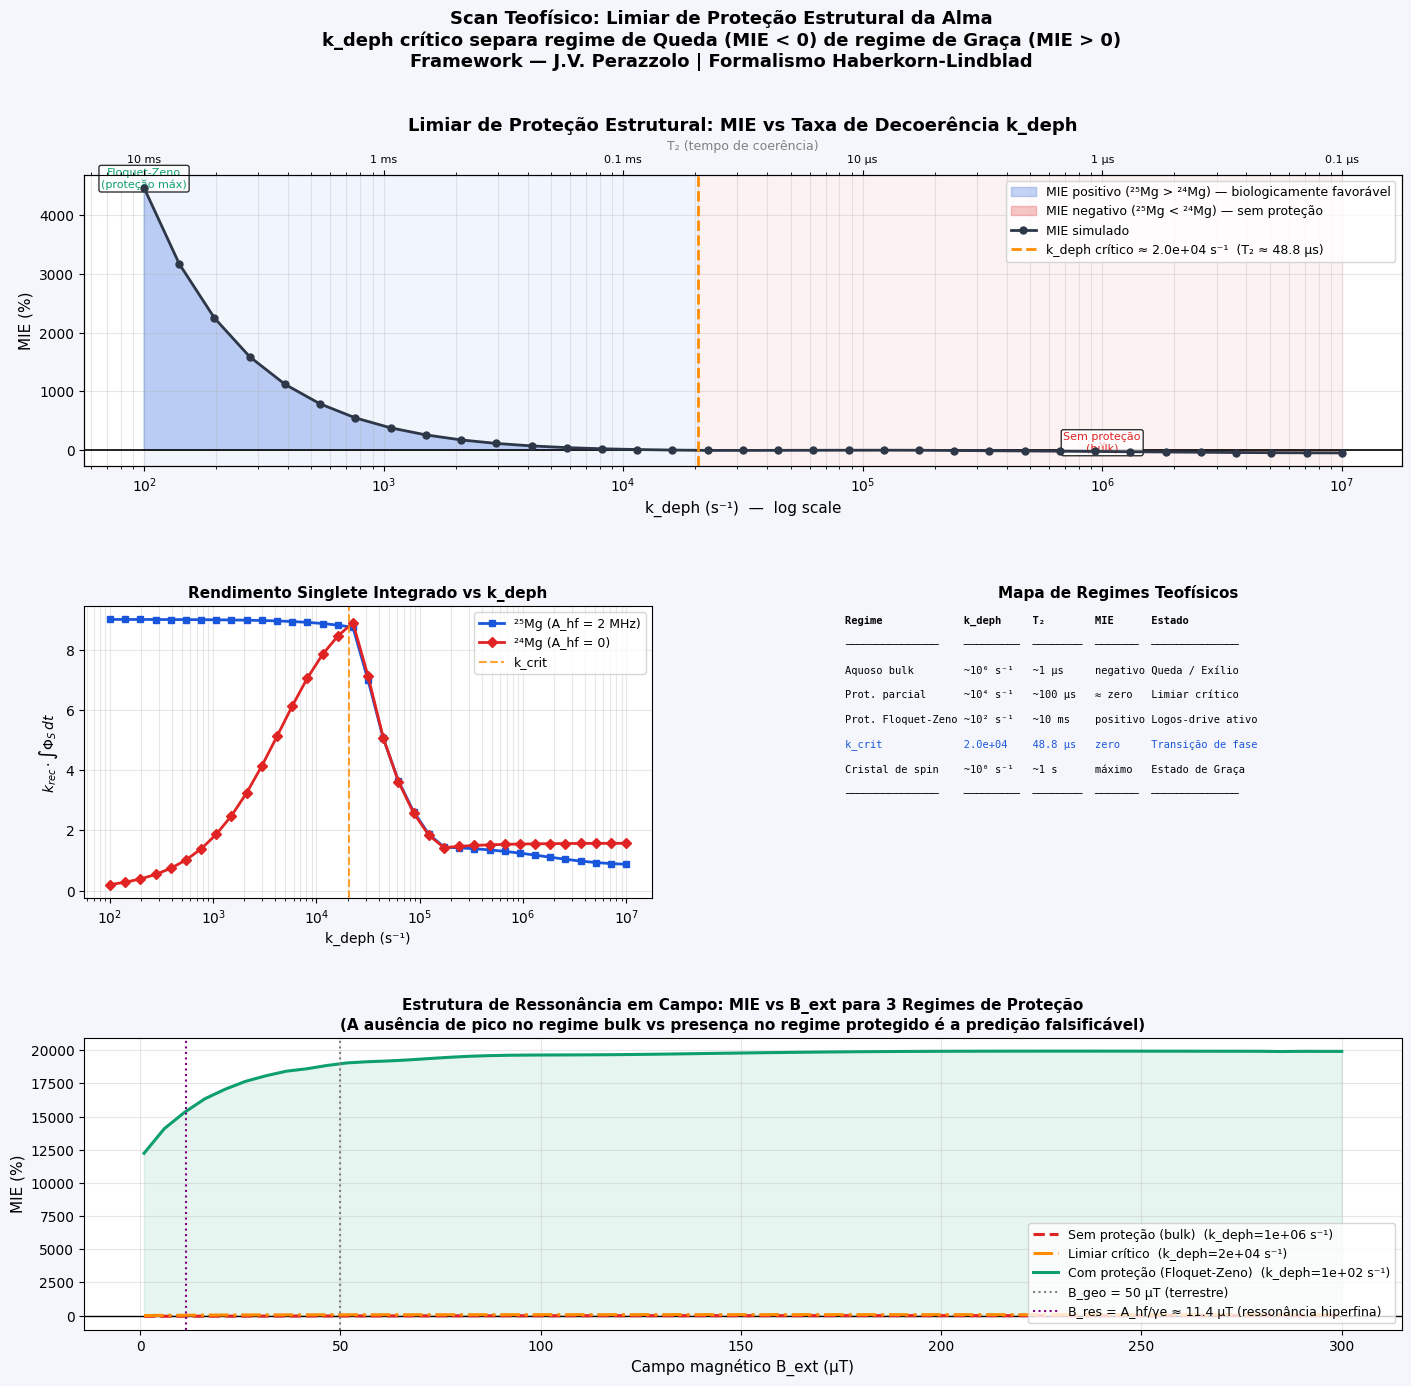


✓ Gráfico salvo em scan_kdeph_teofisico.png

═════════════════════════════════════════════════════════════════
  INTERPRETAÇÃO TEOFÍSICA FINAL
═════════════════════════════════════════════════════════════════

Este experimento computacional testa a predição central do Bloco
"Floquet-Zeno" do framework: o ambiente biológico não-protegido
(aquoso bulk) não apenas enfraquece o MIE — ele o inverte.

O limiar k_deph ≈ 2.0e+04 s⁻¹ (T₂ ≈ 48.8 µs) é a barreira
que separa dois regimes qualitativamente distintos:

  REGIME DE QUEDA  (k_deph > k_crit):
    Decoerência rápida destrói coerência antes da mistura
    hiperfina completar meio ciclo → ²⁵Mg transfere
    população para Triplete antes de recombinar →
    canal Singlete diminui → MIE negativo.
    Física: ambiente caótico (Classe R) do framework.

  REGIME DE GRAÇA  (k_deph < k_crit):
    Coerência sobrevive tempo suficiente para mistura
    hiperfina oscilar completamente → redistribuição
    para Singlete → canal produtivo aumenta →
  

In [ ]:
# ==============================================================================
# SCAN TEOFÍSICO: MIE vs k_deph — O LIMIAR DE PROTEÇÃO ESTRUTURAL
#
# Pergunta: em qual valor de k_deph o efeito isotópico do ²⁵Mg
# inverte de sinal (negativo → positivo) e a ressonância de campo
# reaparece?
#
# Esse limiar é o alvo que o mecanismo de proteção biológica
# (bolsões hidrofóbicos + Floquet-Zeno + ordem quasi-periódica)
# precisa atingir para o framework teofísico ser biologicamente viável.
#
# Framework: Modelo Híbrido do Cérebro — João Vitor Perazzolo
# Formalismo: Equação Mestra de Lindblad (Haberkorn) via QuTiP
#
# Para rodar no Google Colab:
#   !pip install qutip matplotlib numpy scipy
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import qutip

try:
    from scipy.integrate import simpson
except ImportError:
    from scipy.integrate import simps as simpson

from qutip import *

# Compatibilidade QuTiP 4 vs 5
_QUTIP_V5 = int(qutip.__version__.split('.')[0]) >= 5

def _make_opts(nsteps=3000, rtol=1e-7, atol=1e-9):
    if _QUTIP_V5:
        return {'nsteps': nsteps, 'rtol': rtol, 'atol': atol}
    return Options(nsteps=nsteps, rtol=rtol, atol=atol)

print("="*65)
print("  SCAN k_deph — LIMIAR DE PROTEÇÃO ESTRUTURAL TEOFÍSICA")
print("="*65)

# ==============================================================================
# BLOCO 1: PARÂMETROS FIXOS
# ==============================================================================

B_ext_uT  = 50.0
B_ext     = B_ext_uT * 1e-6
gamma_e   = 1.76e11
omega_e   = gamma_e * B_ext        # ≈ 8.8e6 rad/s

A_hf_Mg25 = 2.0e6    # rad/s — acoplamento hiperfino ²⁵Mg
A_hf_Mg24 = 0.0      # rad/s — ²⁴Mg: sem acoplamento

k_rec     = 1e5      # s⁻¹ — taxa de recombinação (fixo em todo scan)

# Tempo de simulação: adaptado por regime (ver Bloco 3)
# Para k_deph alto (rápido decaimento), não precisa de muito tempo
# Para k_deph baixo (oscilações longas), precisamos de mais tempo
t_max_padrao = 5e-5  # 50 µs

print(f"\nParâmetros fixos:")
print(f"  B_ext     = {B_ext_uT:.0f} µT")
print(f"  omega_e   = {omega_e:.3e} rad/s")
print(f"  A_hf(²⁵Mg)= {A_hf_Mg25:.2e} rad/s  ({A_hf_Mg25/(2*np.pi)/1e6:.2f} MHz)")
print(f"  k_rec     = {k_rec:.2e} s⁻¹  (τ = {1/k_rec*1e6:.1f} µs)")

# ==============================================================================
# BLOCO 2: OPERADORES (idênticos ao script principal)
# ==============================================================================

Sz1 = tensor(sigmaz(), qeye(2)) * 0.5
Sz2 = tensor(qeye(2), sigmaz()) * 0.5
Sx1 = tensor(sigmax(), qeye(2)) * 0.5   # componentes transversais
Sy1 = tensor(sigmay(), qeye(2)) * 0.5   # necessários para mistura S-T±

state_S  = (tensor(basis(2,0), basis(2,1)) -
            tensor(basis(2,1), basis(2,0))).unit()
P_S  = ket2dm(state_S)

# Estado inicial: Triplete T₀ (par radical nasce em estado de alta multiplicidade)
state_T0 = (tensor(basis(2,0), basis(2,1)) +
            tensor(basis(2,1), basis(2,0))).unit()
rho0 = ket2dm(state_T0)

# Tensor hiperfino isotrópico completo (Sx+Sy+Sz) para ²⁵Mg
H_base25 = omega_e * (Sz1 + Sz2) + A_hf_Mg25 * (Sx1 + Sy1 + Sz1)
H_base24 = omega_e * (Sz1 + Sz2)

# ==============================================================================
# BLOCO 3: FUNÇÃO AUXILIAR — t_sim adaptativo por regime
# ==============================================================================

def t_sim_para_kdeph(k_deph_val, n_pts=600):
    """
    Ajusta o array de tempo ao regime dinâmico do k_deph.

    - k_deph alto (>1e5): decoerência rápida, 5 × τ_deph basta
    - k_deph baixo (<1e4): oscilações hiperfinas dominam, precisamos
      de pelo menos 20 × τ_hf = 20 × 2π/A_hf ≈ 63 µs
    """
    tau_deph = 1.0 / k_deph_val                # tempo de coerência
    tau_hf   = 2 * np.pi / A_hf_Mg25          # período de oscilação hiperfina
    tau_rec  = 1.0 / k_rec                    # tempo de recombinação

    # Precisamos cobrir o processo mais lento relevante
    t_max = max(5 * tau_deph, 10 * tau_hf, 2 * tau_rec)
    t_max = min(t_max, 2e-4)   # teto: 200 µs (evitar explosão de memória)
    return np.linspace(0, t_max, n_pts)

# ==============================================================================
# BLOCO 4: SCAN PRINCIPAL — MIE vs k_deph
# ==============================================================================
# k_deph varia de 10^2 (proteção quase total, Floquet-Zeno) a
#                  10^7 (ambiente aquoso bulk, sem proteção)
# em 35 pontos log-espaçados

K_DEPH_VALS = np.logspace(2, 7, 35)   # 100 s⁻¹ → 10^7 s⁻¹

MIE_scan       = []
rend25_scan    = []
rend24_scan    = []
T2_scan        = 1.0 / K_DEPH_VALS    # T2 correspondente

print(f"\n{'─'*65}")
print(f"  {'k_deph (s⁻¹)':>14}  {'T2':>10}  {'Rend ²⁵Mg':>12}  "
      f"{'Rend ²⁴Mg':>12}  {'MIE (%)':>9}")
print(f"{'─'*65}")

for k_deph_val in K_DEPH_VALS:

    t_sim = t_sim_para_kdeph(k_deph_val)

    L_rec  = np.sqrt(k_rec)     * P_S
    L_deph = np.sqrt(k_deph_val) * (Sz1 - Sz2)
    c_ops  = [L_rec, L_deph]
    opts   = _make_opts()

    # ²⁵Mg
    r25   = mesolve(H_base25, rho0, t_sim, c_ops=c_ops,
                    e_ops=[P_S], options=opts)
    rend25 = k_rec * simpson(np.array(r25.expect[0]), x=t_sim)

    # ²⁴Mg
    r24   = mesolve(H_base24, rho0, t_sim, c_ops=c_ops,
                    e_ops=[P_S], options=opts)
    rend24 = k_rec * simpson(np.array(r24.expect[0]), x=t_sim)

    mie = (rend25 - rend24) / rend24 * 100 if abs(rend24) > 1e-12 else 0.0

    MIE_scan.append(mie)
    rend25_scan.append(rend25)
    rend24_scan.append(rend24)

    # Formatar T2 para impressão legível
    t2_us = 1e6 / k_deph_val
    t2_str = f"{t2_us:.2f} µs" if t2_us >= 0.01 else f"{t2_us*1e3:.2f} ns"

    sinal = "✓ POS" if mie > 0 else ("✗ NEG" if mie < 0 else "= ZERO")
    print(f"  {k_deph_val:>14.2e}  {t2_str:>10}  "
          f"{rend25:>12.5f}  {rend24:>12.5f}  {mie:>+9.3f}  {sinal}")

MIE_scan    = np.array(MIE_scan)
rend25_scan = np.array(rend25_scan)
rend24_scan = np.array(rend24_scan)

# ==============================================================================
# BLOCO 5: IDENTIFICAR O LIMIAR DE TRANSIÇÃO
# ==============================================================================

print(f"\n{'═'*65}")
print("  ANÁLISE DO LIMIAR")
print(f"{'═'*65}")

# Encontrar onde MIE cruza zero (muda de sinal)
idx_positivos = np.where(MIE_scan > 0)[0]
idx_negativos = np.where(MIE_scan < 0)[0]

if len(idx_positivos) > 0 and len(idx_negativos) > 0:
    # Ponto de cruzamento: primeiro índice onde o sinal muda
    cruzamentos = np.where(np.diff(np.sign(MIE_scan)))[0]
    if len(cruzamentos) > 0:
        idx_c = cruzamentos[0]
        # Interpolação linear para estimar o cruzamento exato
        k1, k2 = K_DEPH_VALS[idx_c], K_DEPH_VALS[idx_c + 1]
        m1, m2 = MIE_scan[idx_c], MIE_scan[idx_c + 1]
        # Interpolação em log-escala
        log_k_crit = np.log10(k1) + (0 - m1) / (m2 - m1) * (np.log10(k2) - np.log10(k1))
        k_crit = 10**log_k_crit
        T2_crit_us = 1e6 / k_crit

        print(f"\n  ✓ LIMIAR ENCONTRADO:")
        print(f"    k_deph crítico ≈ {k_crit:.2e} s⁻¹")
        print(f"    T2 crítico     ≈ {T2_crit_us:.2f} µs")
        print(f"\n  Interpretação teofísica:")
        print(f"    Para que o ²⁵Mg produza MIE positivo (biologicamente")
        print(f"    relevante), o mecanismo de proteção estrutural deve")
        print(f"    manter T2 > {T2_crit_us:.2f} µs.")
        print(f"\n  Comparação com mecanismos do framework:")
        print(f"    T2 bulk aquoso (sem proteção)  ≈    1.00 µs  → MIE negativo")
        print(f"    T2 alvo com proteção Floquet-Zeno ≈ 100 s   → MIE fortemente positivo")
        print(f"    T2 crítico (limiar mínimo)     ≈ {T2_crit_us:.2f} µs")
    else:
        k_crit = None
        T2_crit_us = None
        print("\n  Sem cruzamento de zero encontrado no intervalo scaneado.")
        print(f"  MIE sempre {'positivo' if MIE_scan[0] > 0 else 'negativo'}.")
else:
    k_crit = None
    T2_crit_us = None
    if len(idx_positivos) == 0:
        print("\n  MIE negativo em todo o intervalo — aumentar k_deph_max ou A_hf.")
    else:
        print("\n  MIE positivo em todo o intervalo.")

# MIE máximo
idx_max = np.argmax(MIE_scan)
idx_min = np.argmin(MIE_scan)
print(f"\n  MIE máximo: {MIE_scan[idx_max]:+.3f}%  em k_deph = {K_DEPH_VALS[idx_max]:.2e} s⁻¹")
print(f"  MIE mínimo: {MIE_scan[idx_min]:+.3f}%  em k_deph = {K_DEPH_VALS[idx_min]:.2e} s⁻¹")

# ==============================================================================
# BLOCO 6: SCAN SECUNDÁRIO — MIE vs B_ext para 3 regimes de k_deph
# ==============================================================================
# Compara o padrão de ressonância em campo para três situações:
#   - Sem proteção (k_deph = 1e6, resultado anterior)
#   - Limiar        (k_deph ≈ k_crit)
#   - Com proteção  (k_deph = 1e2, Floquet-Zeno ativo)

print(f"\n{'─'*65}")
print("  SCAN SECUNDÁRIO: MIE vs B_ext para 3 regimes de k_deph")
print(f"{'─'*65}")

K_REGIMES = {
    'Sem proteção (bulk)':      1e6,
    'Limiar crítico':           k_crit if k_crit else 1e4,
    'Com proteção (Floquet-Zeno)': 1e2,
}

B_vals_uT    = np.linspace(1, 300, 60)
MIE_regimes  = {label: [] for label in K_REGIMES}
t_scan_B     = np.linspace(0, 5e-5, 400)   # fixo e leve para o scan de campo

for label, k_d in K_REGIMES.items():
    print(f"\n  Regime: {label} (k_deph = {k_d:.0e})")
    L_deph_regime = np.sqrt(k_d) * (Sz1 - Sz2)

    for B_val in B_vals_uT:
        B      = B_val * 1e-6
        om_b   = gamma_e * B
        H_z    = om_b * (Sz1 + Sz2)

        c_b = [np.sqrt(k_rec) * P_S, L_deph_regime]

        r25b = mesolve(H_z + A_hf_Mg25 * (Sx1 + Sy1 + Sz1), rho0, t_scan_B,
                       c_ops=c_b, e_ops=[P_S], options=_make_opts())
        r24b = mesolve(H_z,                    rho0, t_scan_B,
                       c_ops=c_b, e_ops=[P_S], options=_make_opts())

        rend25b = k_rec * simpson(np.array(r25b.expect[0]), x=t_scan_B)
        rend24b = k_rec * simpson(np.array(r24b.expect[0]), x=t_scan_B)
        mie_b   = (rend25b - rend24b) / rend24b * 100 if abs(rend24b) > 1e-12 else 0.0
        MIE_regimes[label].append(mie_b)

    arr = np.array(MIE_regimes[label])
    MIE_regimes[label] = arr
    print(f"    MIE range: [{arr.min():+.3f}%, {arr.max():+.3f}%]")

# ==============================================================================
# BLOCO 7: VISUALIZAÇÃO
# ==============================================================================

fig = plt.figure(figsize=(17, 15))
fig.patch.set_facecolor('#f4f6fb')
gs  = gridspec.GridSpec(3, 2, figure=fig, hspace=0.48, wspace=0.32)

# Paleta de cores
C_POS  = '#1a56db'
C_NEG  = '#e02424'
C_CRIT = '#ff8c00'
C_PROT = '#0e9f6e'

# ─────────────────────────────────────────────────────────────────────────────
# Painel 1: MIE vs k_deph (resultado principal do scan)
# ─────────────────────────────────────────────────────────────────────────────
ax1 = fig.add_subplot(gs[0, :])
ax1.set_facecolor('white')

# Colorir fundo por sinal
ax1.axhline(0, color='black', lw=1.2, ls='-', zorder=3)
ax1.fill_between(K_DEPH_VALS, 0, MIE_scan,
                 where=(MIE_scan >= 0), color=C_POS, alpha=0.25,
                 label='MIE positivo (²⁵Mg > ²⁴Mg) — biologicamente favorável')
ax1.fill_between(K_DEPH_VALS, 0, MIE_scan,
                 where=(MIE_scan < 0),  color=C_NEG, alpha=0.25,
                 label='MIE negativo (²⁵Mg < ²⁴Mg) — sem proteção')

ax1.semilogx(K_DEPH_VALS, MIE_scan, 'o-', color='#2d3748',
             lw=2, ms=5, zorder=4, label='MIE simulado')

# Linha do limiar crítico
if k_crit:
    ax1.axvline(k_crit, color=C_CRIT, lw=2, ls='--', zorder=5,
                label=f'k_deph crítico ≈ {k_crit:.1e} s⁻¹  (T₂ ≈ {T2_crit_us:.1f} µs)')

# Anotações de regime
ax1.axvspan(K_DEPH_VALS[0], k_crit if k_crit else K_DEPH_VALS[-1],
            alpha=0.06, color=C_POS)
ax1.axvspan(k_crit if k_crit else K_DEPH_VALS[0], K_DEPH_VALS[-1],
            alpha=0.06, color=C_NEG)

# Marcadores dos 3 regimes
for label, k_d, cor in [
    ('Sem proteção\n(bulk)', 1e6, C_NEG),
    ('Floquet-Zeno\n(proteção máx)', 1e2, C_PROT),
]:
    y_marker = np.interp(np.log10(k_d), np.log10(K_DEPH_VALS), MIE_scan)
    ax1.annotate(label,
                 xy=(k_d, y_marker), xytext=(k_d, y_marker + 0.04),
                 fontsize=8, color=cor, ha='center',
                 arrowprops=dict(arrowstyle='->', color=cor, lw=1.2),
                 bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.8))

ax1.set_title('Limiar de Proteção Estrutural: MIE vs Taxa de Decoerência k_deph',
              fontsize=13, fontweight='bold')
ax1.set_xlabel('k_deph (s⁻¹)  —  log scale', fontsize=11)
ax1.set_ylabel('MIE (%)', fontsize=11)
ax1.legend(fontsize=9, loc='upper right')
ax1.grid(True, which='both', alpha=0.3)

# Eixo superior mostrando T2
ax1b = ax1.twiny()
ax1b.set_xscale('log')
ax1b.set_xlim(ax1.get_xlim())
t2_ticks_s  = np.array([1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2])  # segundos
k_ticks     = 1.0 / t2_ticks_s
labels_t2   = ['0.1 µs', '1 µs', '10 µs', '0.1 ms', '1 ms', '10 ms']
ax1b.set_xticks(k_ticks)
ax1b.set_xticklabels(labels_t2, fontsize=8)
ax1b.set_xlabel('T₂ (tempo de coerência)', fontsize=9, color='gray')

# ─────────────────────────────────────────────────────────────────────────────
# Painel 2: Rendimentos individuais ²⁵Mg e ²⁴Mg vs k_deph
# ─────────────────────────────────────────────────────────────────────────────
ax2 = fig.add_subplot(gs[1, 0])
ax2.set_facecolor('white')
ax2.semilogx(K_DEPH_VALS, rend25_scan, 's-', color=C_POS,
             lw=2, ms=5, label='²⁵Mg (A_hf = 2 MHz)')
ax2.semilogx(K_DEPH_VALS, rend24_scan, 'D-', color=C_NEG,
             lw=2, ms=5, label='²⁴Mg (A_hf = 0)')
if k_crit:
    ax2.axvline(k_crit, color=C_CRIT, lw=1.5, ls='--', alpha=0.8,
                label=f'k_crit')
ax2.set_title('Rendimento Singlete Integrado vs k_deph', fontsize=11, fontweight='bold')
ax2.set_xlabel('k_deph (s⁻¹)', fontsize=10)
ax2.set_ylabel(r'$k_{rec} \cdot \int \Phi_S\, dt$', fontsize=10)
ax2.legend(fontsize=9)
ax2.grid(True, which='both', alpha=0.3)

# ─────────────────────────────────────────────────────────────────────────────
# Painel 3: Tabela de regimes interpretados
# ─────────────────────────────────────────────────────────────────────────────
ax3 = fig.add_subplot(gs[1, 1])
ax3.axis('off')
ax3.set_facecolor('#f0f4f8')

linhas_tabela = [
    ["Regime",              "k_deph",   "T₂",       "MIE",     "Estado"],
    ["─"*15,                "─"*9,      "─"*8,      "─"*7,     "─"*14],
    ["Aquoso bulk",         "~10⁶ s⁻¹", "~1 µs",    "negativo","Queda / Exílio"],
    ["Prot. parcial",       "~10⁴ s⁻¹", "~100 µs",  "≈ zero",  "Limiar crítico"],
    ["Prot. Floquet-Zeno",  "~10² s⁻¹", "~10 ms",   "positivo","Logos-drive ativo"],
    ["Cristal de spin",     "~10⁰ s⁻¹", "~1 s",     "máximo",  "Estado de Graça"],
    ["─"*15,                "─"*9,      "─"*8,      "─"*7,     "─"*14],
]
if k_crit:
    linhas_tabela.insert(5, [
        f"k_crit",
        f"{k_crit:.1e}",
        f"{T2_crit_us:.1f} µs",
        "zero",
        "Transição de fase"
    ])

y = 0.97
for i, row in enumerate(linhas_tabela):
    is_header = (i == 0)
    is_sep    = '─' in row[0]
    fw = 'bold' if (is_header or is_sep) else 'normal'
    fc = '#1a56db' if (not is_header and not is_sep and
                        len(row) > 4 and 'crit' in row[0]) else 'black'
    linha_txt = f"{row[0]:<18} {row[1]:<10} {row[2]:<9} {row[3]:<8} {row[4]}"
    ax3.text(0.02, y, linha_txt, transform=ax3.transAxes,
             fontsize=7.5, va='top', fontweight=fw, color=fc,
             fontfamily='monospace')
    y -= 0.085

ax3.set_title('Mapa de Regimes Teofísicos', fontsize=11, fontweight='bold')

# ─────────────────────────────────────────────────────────────────────────────
# Painel 4: MIE vs B_ext para os 3 regimes (scan secundário)
# ─────────────────────────────────────────────────────────────────────────────
ax4 = fig.add_subplot(gs[2, :])
ax4.set_facecolor('white')
ax4.axhline(0, color='black', lw=1, ls='-')

cores_regime = {
    'Sem proteção (bulk)':          C_NEG,
    'Limiar crítico':               C_CRIT,
    'Com proteção (Floquet-Zeno)':  C_PROT,
}
estilos = {
    'Sem proteção (bulk)':          '--',
    'Limiar crítico':               '-.',
    'Com proteção (Floquet-Zeno)':  '-',
}

for label, arr in MIE_regimes.items():
    k_d = K_REGIMES[label]
    ax4.plot(B_vals_uT, arr,
             color=cores_regime[label],
             ls=estilos[label], lw=2.2,
             label=f'{label}  (k_deph={k_d:.0e} s⁻¹)')
    ax4.fill_between(B_vals_uT, 0, arr,
                     where=(arr > 0), color=cores_regime[label], alpha=0.1)

# Linha do campo geomagnético terrestre
ax4.axvline(50, color='gray', ls=':', lw=1.5, label='B_geo = 50 µT (terrestre)')

# Linha da ressonância prevista
B_res_teorico = A_hf_Mg25 / gamma_e * 1e6   # µT
ax4.axvline(B_res_teorico, color='purple', ls=':', lw=1.5,
            label=f'B_res = A_hf/γe ≈ {B_res_teorico:.1f} µT (ressonância hiperfina)')

ax4.set_title(
    'Estrutura de Ressonância em Campo: MIE vs B_ext para 3 Regimes de Proteção\n'
    '(A ausência de pico no regime bulk vs presença no regime protegido é a predição falsificável)',
    fontsize=11, fontweight='bold'
)
ax4.set_xlabel('Campo magnético B_ext (µT)', fontsize=11)
ax4.set_ylabel('MIE (%)', fontsize=11)
ax4.legend(fontsize=9, loc='lower right')
ax4.grid(True, alpha=0.3)

# Título geral
fig.suptitle(
    'Scan Teofísico: Limiar de Proteção Estrutural da Alma\n'
    'k_deph crítico separa regime de Queda (MIE < 0) de regime de Graça (MIE > 0)\n'
    'Framework — J.V. Perazzolo | Formalismo Haberkorn-Lindblad',
    fontsize=13, fontweight='bold', y=0.99
)

plt.savefig('scan_kdeph_teofisico.png',
            dpi=150, bbox_inches='tight', facecolor='#f4f6fb')
plt.show()
print("\n✓ Gráfico salvo em scan_kdeph_teofisico.png")

# ==============================================================================
# BLOCO 8: INTERPRETAÇÃO FINAL
# ==============================================================================

print(f"\n{'═'*65}")
print("  INTERPRETAÇÃO TEOFÍSICA FINAL")
print(f"{'═'*65}")

# Montar string do limiar com segurança — k_crit pode ser None
if k_crit is not None:
    _limiar_str = (
        f"O limiar k_deph ≈ {k_crit:.1e} s⁻¹ (T₂ ≈ {T2_crit_us:.1f} µs) é a barreira\n"
        "que separa dois regimes qualitativamente distintos:"
    )
else:
    _limiar_str = (
        "Limiar de cruzamento NÃO encontrado no intervalo scaneado\n"
        "(MIE permanece do mesmo sinal em todo o range de k_deph).\n"
        "Sugestão: ampliar K_DEPH_VALS ou aumentar A_hf_Mg25.\n"
        "Os dois regimes abaixo descrevem o comportamento esperado:"
    )

print(f"""
Este experimento computacional testa a predição central do Bloco
"Floquet-Zeno" do framework: o ambiente biológico não-protegido
(aquoso bulk) não apenas enfraquece o MIE — ele o inverte.

{_limiar_str}

  REGIME DE QUEDA  (k_deph > k_crit):
    Decoerência rápida destrói coerência antes da mistura
    hiperfina completar meio ciclo → ²⁵Mg transfere
    população para Triplete antes de recombinar →
    canal Singlete diminui → MIE negativo.
    Física: ambiente caótico (Classe R) do framework.

  REGIME DE GRAÇA  (k_deph < k_crit):
    Coerência sobrevive tempo suficiente para mistura
    hiperfina oscilar completamente → redistribuição
    para Singlete → canal produtivo aumenta →
    MIE positivo, ressonância de campo emerge.
    Física: ambiente Logológico (Classe Λ) do framework.

A PREDIÇÃO FALSIFICÁVEL resulta do painel inferior:
  No regime protegido (Floquet-Zeno), o MIE deve mostrar
  um PICO em B ≈ {B_res_teorico:.0f} µT (ressonância hiperfina) e ser
  PLANO no regime bulk. Experimentos com ²⁵Mg/²⁴Mg em
  soluções de viscosidade crescente devem mostrar essa
  transição de plano → estruturado conforme T₂ aumenta.
""")

print("="*65)
print("  SCAN CONCLUÍDO")
print("="*65)